# Capstone Project
*Author: Samuel Leadley*
## Data Cleaning and EDA
## Table of Contents
1. [Load Data](#Load-Data)
2. [Data Cleaning](#Data-Cleaning)
3. [Export Data](#Export-Data)
4. [EDA](#EDA)

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import datetime
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import regex as re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline

## Load Data

In [2]:
shareholder_letters = pd.read_csv('../datasets/leadsheet.csv', encoding='Latin-1')
shareholder_letters.head()

,company,ticker,sector,year,letter_to_shareholders
0,Goldman Sachs,GS,Financials,1999,"This is our first letter to shareholders, incl..."
1,Goldman Sachs,GS,Financials,2000,2000 was a remarkable year for Goldman Sachs a...
2,Goldman Sachs,GS,Financials,2001,It is impossible to discuss 2001 without begin...
3,Goldman Sachs,GS,Financials,2002,It was a challenging year for Goldman Sachs. T...
4,Goldman Sachs,GS,Financials,2003,"Looking back on 2003, we take pride in our per..."


In [3]:
# check shape
shareholder_letters.shape

(166, 5)

## Data Cleaning
### Check for nulls

In [4]:
# check nulls for each column
shareholder_letters.isnull().sum()

company                   0
ticker                    0
sector                    0
year                      0
letter_to_shareholders    0
dtype: int64

### Check Data Types

In [5]:
shareholder_letters.dtypes

company                   object
ticker                    object
sector                    object
year                       int64
letter_to_shareholders    object
dtype: object

### Mapping Target Variable

In [6]:
ticker_lst = list(shareholder_letters['ticker'].unique())
ticker_lst

['GS', 'BAC', 'CVX', 'HAL', 'QCOM', 'IBM', 'ADBE', 'XRX', 'UHS', 'UNH', 'CVS']

In [7]:
# reading in net income data for each company
ni_data = pd.read_csv('../datasets/ni_data.csv')
ni_data.head()

,year,net_income,unit,ticker,target
0,2018,10.46B,B,GS,1.0
1,2017,4.286B,B,GS,0.0
2,2016,7.398B,B,GS,1.0
3,2015,6.083B,B,GS,0.0
4,2014,8.477B,B,GS,1.0


Net income data was collected from y-charts, an online financial data research company. The net income data came in either billions (denoted by a B) or millions (denoted by a M). Below I will convert all figures into billions. The target variable was calculated in excel by comparing the net income from the previous year to that of the current year. If the net income increase year-over-year it was labeled as a 1 and if it had decreased it was labeled as a 0 (there were no istances of neither an increase nor decrease). 

In [8]:
ni_data['net_income'] = [i.replace('B', '') for i in ni_data['net_income']]
ni_data['net_income'] = [i.replace('M', '') for i in ni_data['net_income']]
ni_data['net_income'] = ni_data['net_income'].astype(float)

In [9]:
def net_income_to_B(df):
    for row,value in enumerate(df['net_income']):
        if df['unit'][row] == 'B':
            df['net_income'][row] = value * 1
        else:
            df['net_income'][row] = value * 0.001
    return(df)

In [10]:
ni_data = net_income_to_B(ni_data)

/Users/samuelleadley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/samuelleadley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
ni_data.head()

,year,net_income,unit,ticker,target
0,2018,10.460,B,GS,1.0
1,2017,4.286,B,GS,0.0
2,2016,7.398,B,GS,1.0
3,2015,6.083,B,GS,0.0
4,2014,8.477,B,GS,1.0


In [12]:
shareholder_letters.head()

,company,ticker,sector,year,letter_to_shareholders
0,Goldman Sachs,GS,Financials,1999,"This is our first letter to shareholders, incl..."
1,Goldman Sachs,GS,Financials,2000,2000 was a remarkable year for Goldman Sachs a...
2,Goldman Sachs,GS,Financials,2001,It is impossible to discuss 2001 without begin...
3,Goldman Sachs,GS,Financials,2002,It was a challenging year for Goldman Sachs. T...
4,Goldman Sachs,GS,Financials,2003,"Looking back on 2003, we take pride in our per..."


In [13]:
ni_data['index'] = ni_data['ticker'] + ni_data['year'].astype(str)
shareholder_letters['index'] = shareholder_letters['ticker'] + shareholder_letters['year'].astype(str)

In [14]:
shareholder_letters = pd.merge(shareholder_letters, ni_data, on='index')
shareholder_letters.drop(['index', 'year_y', 'ticker_y', 'unit'], axis = 1, inplace=True)
shareholder_letters.columns = ['company', 'ticker', 'sector', 'year', 'letter_to_shareholder', 'net_income', 'target']

In [15]:
shareholder_letters.head()

,company,ticker,sector,year,letter_to_shareholder,net_income,target
0,Goldman Sachs,GS,Financials,1999,"This is our first letter to shareholders, incl...",2.708,NaN
1,Goldman Sachs,GS,Financials,2000,2000 was a remarkable year for Goldman Sachs a...,3.067,1.0
2,Goldman Sachs,GS,Financials,2001,It is impossible to discuss 2001 without begin...,2.310,0.0
3,Goldman Sachs,GS,Financials,2002,It was a challenging year for Goldman Sachs. T...,2.114,0.0
4,Goldman Sachs,GS,Financials,2003,"Looking back on 2003, we take pride in our per...",3.005,1.0


In [16]:
shareholder_letters.isnull().sum()

company                  0
ticker                   0
sector                   0
year                     0
letter_to_shareholder    0
net_income               0
target                   1
dtype: int64

In [17]:
shareholder_letters[shareholder_letters['target'].isnull() == True]

,company,ticker,sector,year,letter_to_shareholder,net_income,target
0,Goldman Sachs,GS,Financials,1999,"This is our first letter to shareholders, incl...",2.708,NaN


In [19]:
# imputing the first Goldman Sachs letter to shareholders as positive after manually reading it
shareholder_letters['target'][0] = 1

/Users/samuelleadley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Goldman Sachs IPO'd in 1999 so y-charts did not have any net income data prior to 1999. Thus I could not compare the net income year-over-year. Instead I read the letter to shareholders and dermined it was positive. 

In [20]:
shareholder_letters.head()

,company,ticker,sector,year,letter_to_shareholder,net_income,target
0,Goldman Sachs,GS,Financials,1999,"This is our first letter to shareholders, incl...",2.708,1.0
1,Goldman Sachs,GS,Financials,2000,2000 was a remarkable year for Goldman Sachs a...,3.067,1.0
2,Goldman Sachs,GS,Financials,2001,It is impossible to discuss 2001 without begin...,2.310,0.0
3,Goldman Sachs,GS,Financials,2002,It was a challenging year for Goldman Sachs. T...,2.114,0.0
4,Goldman Sachs,GS,Financials,2003,"Looking back on 2003, we take pride in our per...",3.005,1.0


### Clean Text

In [21]:
shareholder_letters['letter_to_shareholder'] = shareholder_letters['letter_to_shareholder'].astype(str)

In [22]:
shareholder_letters['letter_to_shareholder'] = shareholder_letters['letter_to_shareholder'].apply(lambda x: re.sub('[^ a-zA-Z]','', x).lower())


I removed all punctuation from the letters to just get the text because my goal is to determine the sentiment from the letters based purely on the text. 

In [24]:
shareholder_letters.head()

,company,ticker,sector,year,letter_to_shareholder,net_income,target
0,Goldman Sachs,GS,Financials,1999,this is our first letter to shareholders inclu...,2.708,1.0
1,Goldman Sachs,GS,Financials,2000,was a remarkable year for goldman sachs and a...,3.067,1.0
2,Goldman Sachs,GS,Financials,2001,it is impossible to discuss without beginning...,2.310,0.0
3,Goldman Sachs,GS,Financials,2002,it was a challenging year for goldman sachs th...,2.114,0.0
4,Goldman Sachs,GS,Financials,2003,looking back on we take pride in our performa...,3.005,1.0


In [25]:
# check the balance of target
shareholder_letters['target'].value_counts(normalize=True)

1.0    0.692771
0.0    0.307229
Name: target, dtype: float64

## Export Data

In [26]:
shareholder_letters.to_csv('../datasets/clean_df.csv')

## EDA
### CountVectorizer with Entire Corpus

In [27]:
# Instantiate CountVectorizer to see which words are most common in the letters to shareholders
# Removed stop words to see the more unique words that appear
cvec = CountVectorizer(stop_words='english')
# Fit CountVectorizer to title
cvec.fit(shareholder_letters['letter_to_shareholder'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [28]:
# Transform the corpus
freq = cvec.transform(shareholder_letters['letter_to_shareholder'])
# Convert into a DataFrame
freq_df = pd.DataFrame(freq.toarray(), columns = cvec.get_feature_names())

In [29]:
freq_df.shape

(166, 13493)

The number of features, i.e. words, seems very low but I am unsure what is causing this. 

In [30]:
# Looking at the initial list of most common words in the letters to shareholders
freq_df.mean().sort_values(ascending=False)[0:21]

business      9.981928
percent       8.313253
new           7.909639
year          7.728916
billion       7.222892
growth        7.180723
services      5.789157
clients       5.500000
company       5.319277
customers     5.120482
market        4.969880
technology    4.475904
global        4.469880
years         4.361446
health        4.198795
financial     4.060241
markets       3.951807
businesses    3.903614
care          3.765060
capital       3.759036
management    3.674699
dtype: float64

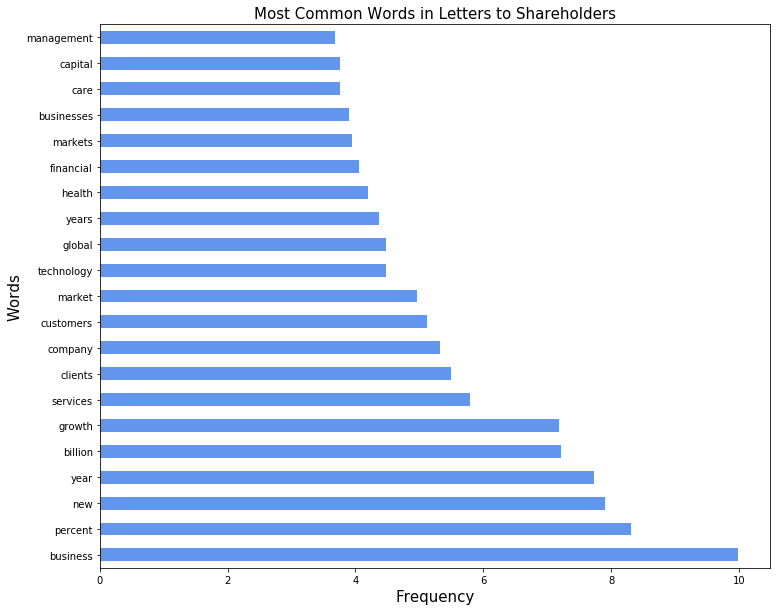

In [31]:
# Visualization of most frequent words in the letters to shareholders
plt.figure(figsize = (12, 10))
freq_df.mean().sort_values(ascending=False)[0:21].plot(kind = 'barh', color='cornflowerblue')

plt.xlabel('Frequency', size = 15)
plt.ylabel('Words', size = 15)
plt.title('Most Common Words in Letters to Shareholders', size = 15);

The above graph shows the most common words in the letters to shareholders. It is not surprising that words like business, percent, and year are some of the most common words.

### CountVectorizer with Positive Class

In [33]:
# created a positive class dataframe to look at what words are common in just the positive letters
positive_class = shareholder_letters[shareholder_letters['target'] == 1][['letter_to_shareholder']]

In [34]:
# Instantiate CountVectorizer to see which words are most common in the positive letters to shareholders
# Removed stop words to see the more unique words that appear
cvec = CountVectorizer(stop_words='english')
# Fit CountVectorizer to title
cvec.fit(positive_class['letter_to_shareholder'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [35]:
# Transform the corpus
pos_freq = cvec.transform(positive_class['letter_to_shareholder'])
# Convert into a DataFrame
pos_freq_df = pd.DataFrame(pos_freq.toarray(), columns = cvec.get_feature_names())

In [36]:
# Looking at the initial list of most common words in the positive letters to shareholders
pos_freq_df.mean().sort_values(ascending=False)[0:21]

business      9.504348
percent       8.521739
new           8.069565
year          7.443478
growth        7.304348
billion       7.200000
services      5.704348
clients       5.669565
company       5.582609
health        4.921739
customers     4.895652
market        4.860870
care          4.417391
years         4.382609
global        4.130435
technology    4.060870
financial     3.930435
markets       3.886957
capital       3.791304
management    3.704348
businesses    3.643478
dtype: float64

In [37]:
# create a dataframe of the positive words to later compare to the top words in the negative class
positive_words = pd.DataFrame(pos_freq_df.mean().sort_values(ascending=False))
positive_words.reset_index(inplace=True)

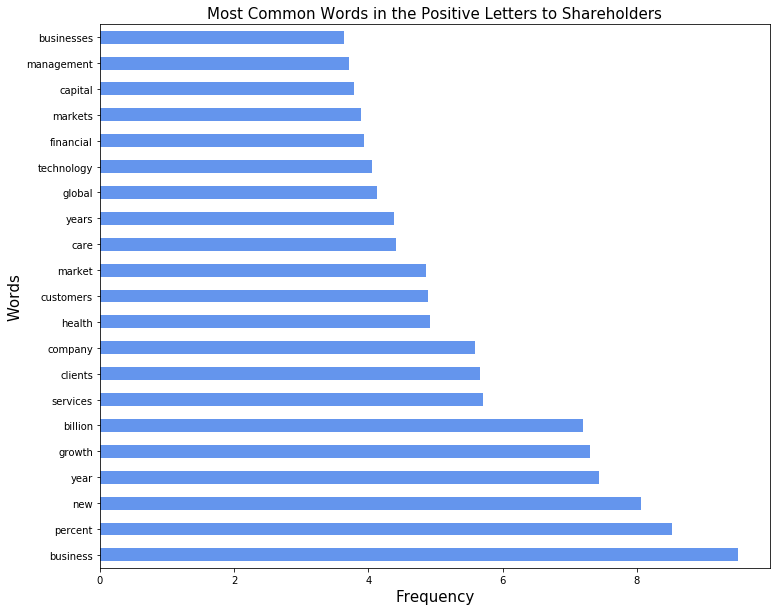

In [38]:
# Visualization of most frequent words in the letters to shareholders
plt.figure(figsize = (12, 10))
pos_freq_df.mean().sort_values(ascending=False)[0:21].plot(kind = 'barh', color='cornflowerblue')

plt.xlabel('Frequency', size = 15)
plt.ylabel('Words', size = 15)
plt.title('Most Common Words in the Positive Letters to Shareholders', size = 15);

The words are very similar to that of the whole corpus with the first four words exactly the same. This may indicate that using TfIdf may be a better vectorizer to use because it will penalize words that are common within the corpus. Otherwise there are no real surpises in the above graph.

### CountVectorizer with Negative Class

In [39]:
# created a negative class to look at the unique words that may only be attributable to the negative class
negative_class = shareholder_letters[shareholder_letters['target'] == 0][['letter_to_shareholder']]

In [40]:
# Instantiate CountVectorizer to see which words are most common in the negative letters to shareholders
# Removed stop words to see the more unique words that appear
cvec = CountVectorizer(stop_words='english')
# Fit CountVectorizer to title
cvec.fit(negative_class['letter_to_shareholder'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [41]:
# Transform the corpus
neg_freq = cvec.transform(negative_class['letter_to_shareholder'])
# Convert into a DataFrame
neg_freq_df = pd.DataFrame(neg_freq.toarray(), columns = cvec.get_feature_names())

In [43]:
# Looking at the initial list of most common words in the negative letters to shareholders
neg_freq_df.mean().sort_values(ascending=False)[0:21]

business      11.058824
year           8.372549
percent        7.843137
new            7.549020
billion        7.274510
growth         6.901961
services       5.980392
customers      5.627451
technology     5.411765
global         5.235294
market         5.215686
clients        5.117647
company        4.725490
businesses     4.490196
financial      4.352941
years          4.313725
industry       4.274510
markets        4.098039
work           3.843137
continue       3.764706
capital        3.686275
dtype: float64

In [44]:
# create a dataframe of the negative words to later compare to the top words in the negative class
negative_words = pd.DataFrame(neg_freq_df.mean().sort_values(ascending=False))
negative_words.reset_index(inplace=True)

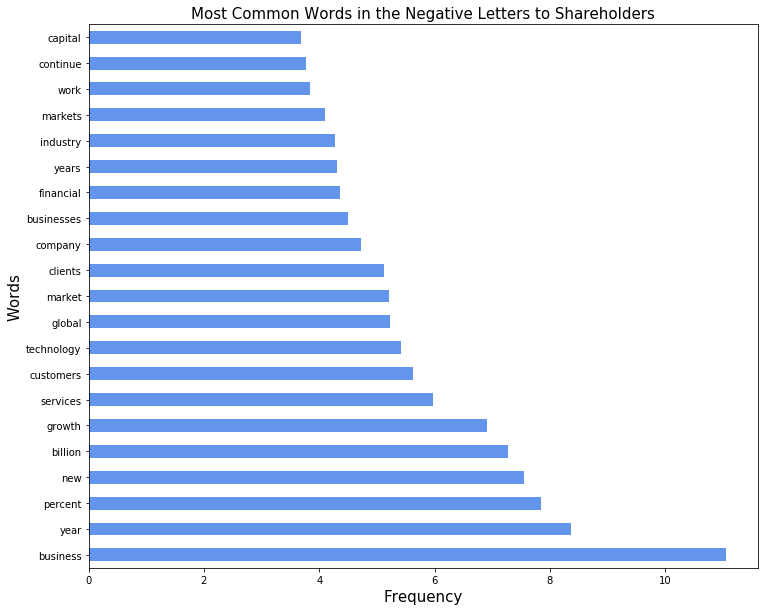

In [45]:
# Visualization of most frequent words in the letters to shareholders
plt.figure(figsize = (12, 10))
neg_freq_df.mean().sort_values(ascending=False)[0:21].plot(kind = 'barh', color='cornflowerblue')

plt.xlabel('Frequency', size = 15)
plt.ylabel('Words', size = 15)
plt.title('Most Common Words in the Negative Letters to Shareholders', size = 15);

Both the positive and negative letters to shareholders have very similar words. It is logical that most of these words would come up in both classes because the letters are written using very similar jargon and discourse. However, since many of these words are common among both classes I may make a custom stop words list with them included as they do not help the algorithm classify the letters. 

### Positve vs. Negative Words

In [ ]:
set(positive_words['index']) - set(negative_words['index']) 

In [ ]:
set(negative_words['index']) - set(positive_words['index'])

In [52]:
words_to_remove = list(set(negative_words['index']) & set(positive_words['index']))

In [53]:
words_to_remove_df = pd.DataFrame(words_to_remove)

The words in both the positive and negative class are not very useful to the model so I will add them to my custom stop words list in the preprocessing step before modeling. 

In [55]:
# export words_to_remove for use in preprocessing
words_to_remove_df.to_csv('../datasets/words_to_remove.csv')

### CountVectorizer with Entire Corpus: ngram_range = (2, 2)

In [56]:
# Instantiate CountVectorizer to see which words are most common in the letters to shareholders
# Removed stop words to see the more unique words that appear
cvec = CountVectorizer(stop_words='english', ngram_range=(2,2))
# Fit CountVectorizer to title
cvec.fit(shareholder_letters['letter_to_shareholder'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(2, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [57]:
# Transform the corpus
freq = cvec.transform(shareholder_letters['letter_to_shareholder'])
# Convert into a DataFrame
freq_df = pd.DataFrame(freq.toarray(), columns = cvec.get_feature_names())

In [58]:
# Looking at the initial list of most common words in the letters to shareholders
freq_df.mean().sort_values(ascending=False)[0:21]

goldman sachs         2.066265
health care           1.771084
past years            0.915663
cash flow             0.897590
united states         0.813253
investment banking    0.734940
bank america          0.680723
net revenues          0.680723
earnings share        0.668675
products services     0.608434
balance sheet         0.602410
business model        0.536145
financial services    0.536145
risk management       0.524096
net income            0.512048
board directors       0.500000
increased percent     0.463855
years ago             0.463855
natural gas           0.457831
market share          0.439759
customers clients     0.421687
dtype: float64

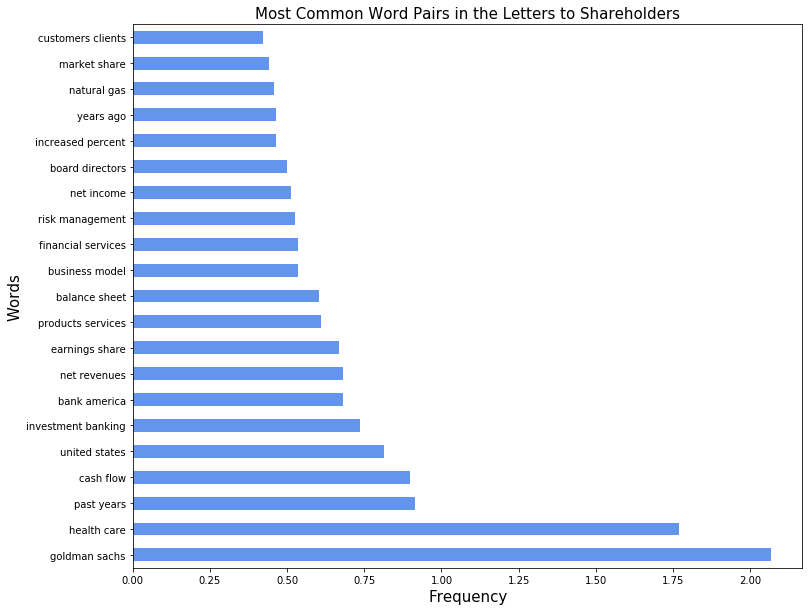

In [59]:
# Visualization of most frequent words in the letters to shareholders
plt.figure(figsize = (12, 10))
freq_df.mean().sort_values(ascending=False)[0:21].plot(kind = 'barh', color='cornflowerblue')

plt.xlabel('Frequency', size = 15)
plt.ylabel('Words', size = 15)
plt.title('Most Common Word Pairs in the Letters to Shareholders', size = 15);

It is interesting that one company (Goldman Sachs) referenced itself so much it comes up as the most common word in the corpus. Apart from Bank of America (above as bank america) no other company references itself very much. Other word pairs like those referring to financial metrics (i.e. net revenues) are not surprising. 

### CountVectorizer with Positive Class: ngram_range = (2, 2)

In [60]:
# Instantiate CountVectorizer to see which word pairs are most common in the positive letters to shareholders
# Removed stop words to see the more unique words that appear
cvec = CountVectorizer(stop_words='english', ngram_range=(2,2))
# Fit CountVectorizer to title
cvec.fit(positive_class['letter_to_shareholder'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(2, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [61]:
# Transform the corpus
pos_freq = cvec.transform(positive_class['letter_to_shareholder'])
# Convert into a DataFrame
pos_freq_df = pd.DataFrame(pos_freq.toarray(), columns = cvec.get_feature_names())

In [62]:
# Looking at the initial list of most common word pairs in the positive letters to shareholders
pos_freq_df.mean().sort_values(ascending=False)[0:21]

health care           2.000000
goldman sachs         1.965217
united states         0.939130
past years            0.930435
cash flow             0.921739
earnings share        0.730435
investment banking    0.721739
net revenues          0.713043
bank america          0.669565
business model        0.591304
risk management       0.565217
board directors       0.565217
balance sheet         0.565217
products services     0.556522
increased percent     0.539130
behavioral health     0.486957
customers clients     0.469565
net income            0.469565
financial services    0.452174
acute care            0.443478
years ago             0.443478
dtype: float64

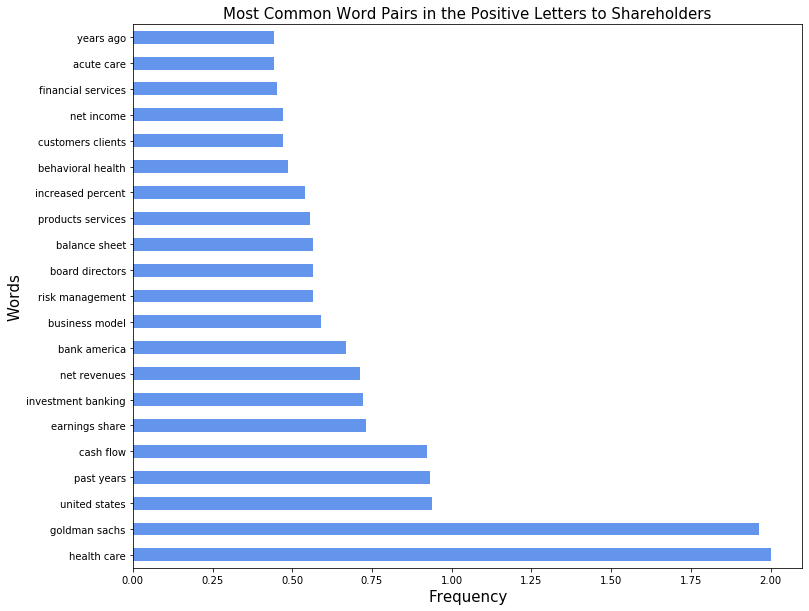

In [69]:
# Visualization of most frequent word pairs in the letters to shareholders
plt.figure(figsize = (12, 10))
pos_freq_df.mean().sort_values(ascending=False)[0:21].plot(kind = 'barh', color='cornflowerblue')

plt.xlabel('Frequency', size = 15)
plt.ylabel('Words', size = 15)
plt.title('Most Common Word Pairs in the Positive Letters to Shareholders', size = 15);

It is not surpising that the postive word pairs are very similar to the whole corpus. There is little information gleaned from the above graph.

### CountVectorizer with Negative Class: ngram_range(2, 2)

In [64]:
# Instantiate CountVectorizer to see which word pairs are most common in the negative letters to shareholders
# Removed stop words to see the more unique words that appear
cvec = CountVectorizer(stop_words='english', ngram_range=(2,2))
# Fit CountVectorizer to title
cvec.fit(negative_class['letter_to_shareholder'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(2, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [65]:
# Transform the corpus
neg_freq = cvec.transform(negative_class['letter_to_shareholder'])
# Convert into a DataFrame
neg_freq_df = pd.DataFrame(neg_freq.toarray(), columns = cvec.get_feature_names())

In [66]:
# Looking at the initial list of most common words in the positive letters to shareholders
neg_freq_df.mean().sort_values(ascending=False)[0:21]

goldman sachs         2.294118
health care           1.254902
past years            0.882353
cash flow             0.843137
investment banking    0.764706
financial services    0.725490
products services     0.725490
bank america          0.705882
balance sheet         0.686275
net revenues          0.607843
wealth management     0.607843
net income            0.607843
united states         0.529412
natural gas           0.529412
market share          0.529412
earnings share        0.529412
years ago             0.509804
growth markets        0.509804
economic growth       0.490196
north america         0.490196
small businesses      0.470588
dtype: float64

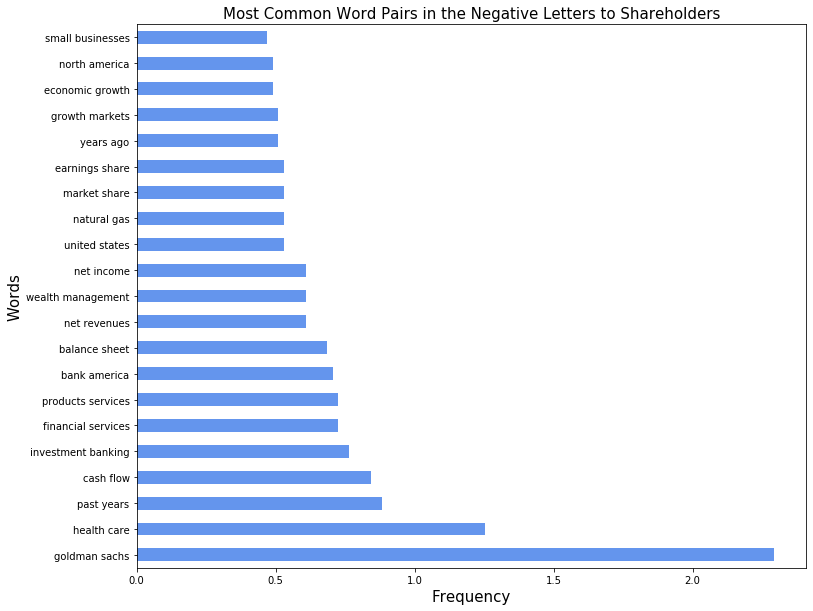

In [67]:
# Visualization of most frequent words in the letters to shareholders
plt.figure(figsize = (12, 10))
neg_freq_df.mean().sort_values(ascending=False)[0:21].plot(kind = 'barh', color='cornflowerblue')

plt.xlabel('Frequency', size = 15)
plt.ylabel('Words', size = 15)
plt.title('Most Common Word Pairs in the Negative Letters to Shareholders', size = 15);

Again, there are only slight, unsurprising differences between the most common words pairs in the negative class compared to the positive class and the entire corpus. 

### Industry EDA

In [70]:
ls = []
for letter in shareholder_letters['letter_to_shareholder']:
    length = len(letter)
    ls.append(length)
    letter_len = pd.DataFrame(ls)

In [71]:
shareholder_letters = pd.concat([shareholder_letters, letter_len], axis = 1)
shareholder_letters.rename(columns={0: 'length'}, inplace=True)

In [72]:
avg_sector_lengths = shareholder_letters.groupby('sector').mean()[['length']]

<Figure size 864x720 with 0 Axes>

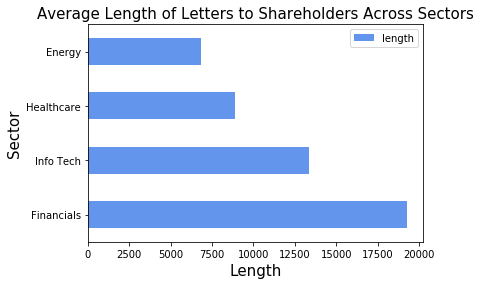

In [73]:
# Visualization of most frequent words in the letters to shareholders
plt.figure(figsize = (12, 10))
avg_sector_lengths.sort_values(by = 'length', ascending=False).plot(kind = 'barh', color='cornflowerblue')

plt.xlabel('Length', size = 15)
plt.ylabel('Sector', size = 15)
plt.title('Average Length of Letters to Shareholders Across Sectors', size = 15);

As evidenced by tha graph above there are clear differences in the length of shareholders letters in each sector. The finacials sector has quite verbose letters to its shareholders while the energy sector like to keep its letters fairly short.

In [74]:
postive_vs_negative_years = shareholder_letters.groupby('sector').mean()[['target']]

<Figure size 864x720 with 0 Axes>

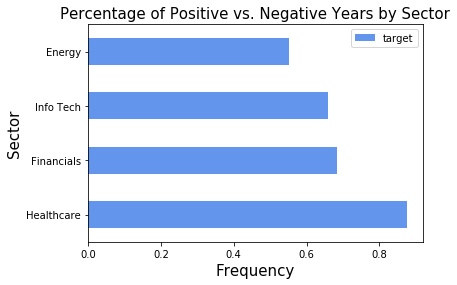

In [75]:
# Visualization of most frequent words in the letters to shareholders
plt.figure(figsize = (12, 10))
postive_vs_negative_years.sort_values(by = 'target', ascending=False).plot(kind = 'barh', color='cornflowerblue')

plt.xlabel('Frequency', size = 15)
plt.ylabel('Sector', size = 15)
plt.title('Percentage of Positive vs. Negative Years by Sector', size = 15);

Looking at the graph above we can infer that the Heathcare sector fared the best over the time period having positive years more than 70 percent of the time while the Info Tech sector did the worst. Info Tech likley perfromed worse than the other sectors because of the dot com bubble however I am surpised that the financials sector fared second best seeing as it was also hit hard by the 2008 recession. 